# ARGUMENTS AND PARAMETERS
Consistent with what has been used in the rest of the work

In [0]:
# Directories
DATA_DIR = 'data'       # Directory where the dataset will be downloaded

# Settings
DEVICE = 'cuda'

# Dataset
RANDOM_STATE = 420      # For reproducibility of results                        
                        # Note: different random states give very different
                        # splits and therefore very different results.

NUM_CLASSES = 100       # Total number of classes
NUM_BATCHES = 10
CLASS_BATCH_SIZE = 10   # Size of batch of classes for incremental learning

VAL_SIZE = 0.1          # Proportion of validation set with respect to training set (between 0 and 1)

# Training
BATCH_SIZE = 64         # Batch size (iCaRL sets this to 128)
LR = 2                  # Initial learning rate
                        # iCaRL sets LR = 2
MOMENTUM = 0.9          # Momentum for stochastic gradient descent (SGD)
WEIGHT_DECAY = 1e-5     # Weight decay from iCaRL

NUM_RUNS = 3            # Number of runs of every method
                        # Note: this should be at least 3 to have a fair benchmark

NUM_EPOCHS = 70         # Total number of training epochs
MILESTONES = [49, 63]   # Step down policy from iCaRL (MultiStepLR)
                        # Decrease the learning rate by gamma at each milestone
GAMMA = 0.2             # Gamma factor from iCaRL

In [2]:
#import libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.backends import cudnn
from torch.utils.data import Subset, DataLoader
import torchvision
import torchvision.transforms as transforms
from copy import deepcopy
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preparation
Load the CIFAR100 dataset and split it into train, val and test sets

Apply transformations to the datasets

In [3]:
#Data Loading and Transformations

train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform =  transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)


# having the same random state as the rest of the notebook ensures that the train and evaluation splits of the dataset are the same

len_dataset = len(train_dataset)
indices = list(range(len_dataset))
split = int(np.floor(VAL_SIZE*len_dataset))
rs = np.random.RandomState(RANDOM_STATE)
rs.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataloader= torch.utils.data.DataLoader(Subset(train_dataset, train_indices), batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=4, drop_last=True)

val_dataloader = torch.utils.data.DataLoader(Subset(train_dataset, val_indices), batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=4, drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


# Training

Load the model and train the network on the test set while evaluating the performance at every epoch


In [4]:
!git clone https://github.com/LilMowgli/Resnet-CIFAR-100.git
!mv "Resnet-CIFAR-100" "Resnet"

from Resnet.resnet_cifar100 import resnet32

Cloning into 'Resnet-CIFAR-100'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [5]:
#define the network and expand the output layer to 100 classes

net = resnet32()
in_features = net.fc.in_features
net.fc = nn.Linear(in_features, 100)  
net.to(DEVICE)

#the loss is the binary cross entropy with logits since the activation function is a sigmoid

criterion = nn.BCEWithLogitsLoss()
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR,
				  momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
									   milestones=MILESTONES, gamma=GAMMA)

#train and evaluate the net

cudnn.benchmark

best_accuracy = 0 #these parameters are used in the validation stage
best_epoch = 0
current_epoch = 0

for epoch in range(70): #NUM_EPOCHS = 70
	net.train()          # put the net into training mode
	running_train_loss = 0
	running_corrects = 0
	total = 0
	batch_idx = 0
	current_epoch += 1

	print(f"Epoch: {current_epoch}, LR: {scheduler.get_last_lr()}")

	#training the net 

	for data in train_dataloader:
		images, labels = data
		optimizer.zero_grad()
		images = images.to(DEVICE)
		labels = labels.to(DEVICE)
		one_hot_labels = torch.eye(100)[labels].to(DEVICE)

		outputs = net(images)
		loss = criterion(outputs, one_hot_labels)


		running_train_loss += loss.item()
		_, preds = torch.max(outputs.data, 1)
		corrects = torch.sum(preds == labels.data).data.item()

		loss.backward()
		optimizer.step()

		running_train_loss += loss.item()
		running_corrects += corrects
		total += labels.size(0)
		batch_idx += 1

	scheduler.step() #update the learning rate after each epoch

	#calculate average scores
	train_loss = running_train_loss / batch_idx       # Average over all batches
	train_accuracy = running_corrects / float(total)  # Average over all samples

	print(f"Train loss: {train_loss}, Train accuracy: {train_accuracy}")

	#validation on the same epoch as the training

	net.train(False)

	running_val_loss = 0
	running_corrects = 0
	total = 0
	batch_idx = 0

	for data in val_dataloader:
		images, labels = data
		images = images.to(DEVICE)
		labels = labels.to(DEVICE)
		total += labels.size(0)

		one_hot_labels = torch.eye(100)[labels].to(DEVICE)

		outputs = net(images)
		loss = criterion(outputs, one_hot_labels)

		running_val_loss += loss.item()

		_, preds = torch.max(outputs.data, 1)

		running_corrects += torch.sum(preds == labels.data).data.item()

		batch_idx +=1

	val_loss = running_val_loss / batch_idx
	val_accuracy = running_corrects / float(total)  

	print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

	if val_accuracy > best_accuracy:
		best_accuracy = val_accuracy
		best_net = deepcopy(net)
		best_epoch = epoch
		print("Best model updated")

	print("")
  
#after training over all the epochs, save the state of the network in memory

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)



Epoch: 1, LR: [2]
Train loss: 0.11088092751260502, Train accuracy: 0.049142069701280225
Validation loss: 0.05011765186030131, Validation accuracy: 0.07772435897435898
Best model updated

Epoch: 2, LR: [2]
Train loss: 0.0950779655198454, Train accuracy: 0.10893047652916074
Validation loss: 0.04809998171642805, Validation accuracy: 0.10276442307692307
Best model updated

Epoch: 3, LR: [2]
Train loss: 0.08860816117667542, Train accuracy: 0.1653849573257468
Validation loss: 0.04483861972888311, Validation accuracy: 0.16205929487179488
Best model updated

Epoch: 4, LR: [2]
Train loss: 0.08281731496367652, Train accuracy: 0.2110597439544808
Validation loss: 0.04052451635018373, Validation accuracy: 0.22876602564102563
Best model updated

Epoch: 5, LR: [2]
Train loss: 0.07694997058738855, Train accuracy: 0.26444701280227595
Validation loss: 0.0377922967935984, Validation accuracy: 0.2780448717948718
Best model updated

Epoch: 6, LR: [2]
Train loss: 0.0718679813612491, Train accuracy: 0.31156

# Testing

Test accuracy: 0.6809


<function matplotlib.pyplot.show>

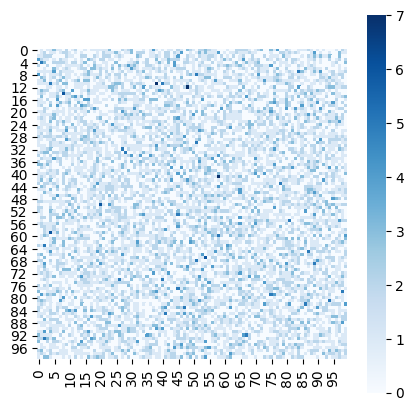

In [6]:
#load the saved trained net from memory, optional

#net = resnet32()
#net.load_state_dict(torch.load(PATH))

best_net.train(False)
running_corrects = 0
total = 0

all_preds = torch.tensor([]) # to store all predictions
all_preds = all_preds.type(torch.LongTensor)

with torch.no_grad():
  for data in test_dataloader:
    images, labels = data
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    total += labels.size(0)
    outputs = best_net(images)

    _, preds = torch.max(outputs.data, 1)

    running_corrects += torch.sum(preds == labels.data).data.item()

    all_preds = torch.cat((all_preds.to(DEVICE), preds.to(DEVICE)), dim=0)

accuracy = running_corrects / float(total)
print(f"Test accuracy: {accuracy}")

#display the confusion matrix

targets = test_dataset.targets
predictions = all_preds.to('cpu').numpy()

cm = confusion_matrix(targets, predictions)

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ax = sns.heatmap(cm, square=True, cmap='Blues', annot=None)
plt.show
